In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os                                                                       
import skimage.draw
import numpy as np                                                              
import tensorflow as tf                                                         
                                                                                
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             

## Model parameters

In [2]:
params = {                                                                      
  ## Model params                                                               
  "out_dir": os.path.expanduser("~")+"/Work/Projects/strongPCA/outputs/",       
  "chk_dir": os.path.expanduser("~")+"/Work/Projects/strongPCA/checkpoints/",   
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/",                        
  "load_chk": True,                                                             
  "update_interval": 100,                                                       
  "device": "/cpu:0",                                                           
  "learning_rate": 0.12,                                                        
  "num_neurons": 500,                                                           
  "sparse_mult": 0.2,                                                           
  "num_inference_steps": 20,                                                    
  "eta": 0.001/0.03, #dt/tau                                                    
  "eps": 1e-12,                                                                 
  ## Data params                                                                
  "data_type": "vanhateren",                                                    
  "rand_state": np.random.RandomState(12345),                                   
  "num_images": 50,                                                          
  "num_batches": 30000,                                                         
  "batch_size": 100,                                                            
  "patch_edge_size": 16,                                                        
  "overlapping_patches": True,                                                  
  "patch_variance_threshold": 1e-6,                                             
  "conv": False,                                                                
  "whiten_images": True}                                                        
                                                                                
## Calculated params                                                            
params["epoch_size"] = params["batch_size"] * params["num_batches"]             
params["num_pixels"] = int(params["patch_edge_size"]**2)                        
params["dataset_shape"] = [int(val)                                             
    for val in [params["epoch_size"], params["num_pixels"]]],                   
params["phi_shape"] = [params["num_pixels"], params["num_neurons"]]             

## Load dataset

In [3]:
data = dp.get_data(params["data_type"], params)                                 
params["input_shape"] = [                                                       
  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

## Define graph

In [4]:
graph = tf.Graph()                                                              
with tf.device(params["device"]):                                               
  with graph.as_default():                                                      
    with tf.name_scope("placeholders") as scope:                                
      x = tf.placeholder(tf.float32, shape=[None,               
        params["num_pixels"]], name="input_data")                               
      sparse_mult = tf.placeholder(tf.float32, shape=(), name="sparse_mult")    
                                                                                
    with tf.name_scope("constants") as scope:                                   
      u_zeros = tf.zeros(shape=tf.stack([tf.shape(x)[0],                        
        params["num_neurons"]]), dtype=tf.float32, name="u_zeros")              
      u_noise = tf.truncated_normal(                                            
        shape=tf.stack([tf.shape(x)[0], params["num_neurons"]]),                
        mean=0.0, stddev=0.1, dtype=tf.float32, name="u_noise")                 
                                                                                
    with tf.name_scope("step_counter") as scope:                                
      global_step = tf.Variable(0, trainable=False, name="global_step")         
                                                                                
    with tf.variable_scope("weights") as scope:                                 
      phi_init = tf.truncated_normal(params["phi_shape"], mean=0.0, stddev=0.5, 
        dtype=tf.float32, name="phi_init")                                  
      phi = tf.get_variable(name="phi", dtype=tf.float32,                       
        initializer=phi_init, trainable=True)                                   
                                                                                
    with tf.name_scope("norm_weights") as scope:                                
      norm_phi = phi.assign(tf.nn.l2_normalize(phi,                             
        dim=0, epsilon=params["eps"], name="row_l2_norm"))                      
      norm_weights = tf.group(norm_phi,                                         
        name="l2_normalization")                                                
                                                                                
    with tf.name_scope("inference") as scope:                                   
      u = tf.Variable(u_zeros, trainable=False,                                 
        validate_shape=False, name="u")                                         
      # soft thresholded, rectified                                             
      a = tf.where(tf.greater(u, sparse_mult),                                  
        tf.subtract(u, sparse_mult), u_zeros,                                   
        name="activity")                                                        
                                                                                
    with tf.name_scope("output") as scope:                                      
      with tf.name_scope("image_estimate"):                                     
        x_ = tf.matmul(a, tf.transpose(phi),                                    
          name="reconstruction")                                                
                                                                                
    with tf.name_scope("loss") as scope:                                        
      with tf.name_scope("unsupervised"):                                       
        recon_loss = tf.reduce_mean(0.5 *                                       
          tf.reduce_sum(tf.pow(tf.subtract(x, x_), 2.0),                        
          axis=[1]), name="recon_loss")                                         
        sparse_loss = sparse_mult * tf.reduce_mean(                             
          tf.reduce_sum(tf.abs(a), axis=[1]),                                   
          name="sparse_loss")                                                   
        unsupervised_loss = (recon_loss + sparse_loss)                          
      total_loss = unsupervised_loss                                            
                                                                                
    with tf.name_scope("update_u") as scope:                                    
      lca_b = tf.matmul(x, phi, name="driving_input")                           
      lca_g = (tf.matmul(tf.transpose(phi), phi,                                
        name="gram_matrix") -                                                   
        tf.constant(np.identity(params["phi_shape"][1], dtype=np.float32),      
        name="identity_matrix"))                                                
      lca_explain_away = tf.matmul(a, lca_g,                                    
        name="explaining_away")                                                 
      du = lca_b - lca_explain_away - u                                         
      step_inference = tf.group(u.assign_add(params["eta"] * du),               
        name="step_inference")                                                  
      reset_activity = tf.group(u.assign(u_zeros),                              
        name="reset_activity")                                                  
                                                                                
    with tf.name_scope("performance_metrics") as scope:                         
      with tf.name_scope("reconstruction_quality"):                             
        MSE = tf.reduce_mean(tf.pow(tf.subtract(x, x_), 2.0),                   
          axis=[1, 0], name="mean_squared_error")                               
                                                                                
    with tf.name_scope("optimizers") as scope:                                  
      learning_rates = tf.train.exponential_decay(                              
        learning_rate=params["learning_rate"],                                  
        global_step=global_step,                                                
        decay_steps=int(np.floor(params["num_batches"]*0.9)),                   
        decay_rate=0.5,                                                         
        staircase=True,                                                         
        name="phi_annealing_schedule")                                          
      optimizer = tf.train.GradientDescentOptimizer(learning_rates,             
        name="phi_optimizer")                                                   
      update_weights = optimizer.minimize(total_loss, global_step=global_step, 
        var_list=[phi], name="phi_minimizer")                                   
                                                                                
    full_saver = tf.train.Saver(var_list=[phi], max_to_keep=2)                  
                                                                                
    with tf.name_scope("summaries") as scope:                                   
      #tf.summary.image("input", tf.reshape(x, [params["batch_size"],           
      #  params["patch_edge_size"], params["patch_edge_size"], 1]))             
      #tf.summary.image("weights", tf.reshape(tf.transpose(phi),                
      #  [params["num_neurons"], params["patch_edge_size"],                     
      #  params["patch_edge_size"], 1]))                                        
      tf.summary.histogram("u", u)                                              
      tf.summary.histogram("a", a)                                              
      tf.summary.histogram("phi", phi)                                          
                                                                                
    merged_summaries = tf.summary.merge_all()                                   
    train_writer = tf.summary.FileWriter(params["out_dir"], graph)              
                                                                                
    with tf.name_scope("initialization") as scope:                              
      init_op = tf.group(tf.global_variables_initializer(),                     
        tf.local_variables_initializer())                                       

## Train LCA model (if needed)

In [5]:
if not params["load_chk"]:
  if not os.path.exists(params["out_dir"]):
    os.makedirs(params["out_dir"])
  if not os.path.exists(params["chk_dir"]):
    os.makedirs(params["chk_dir"])

  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
    feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    
    batch_steps = []
    losses = []
    sparsities = []
    recon_errors = []
    for b_step in range(params["num_batches"]):
      data_batch = data["train"].next_batch(params["batch_size"])
      input_data = data_batch[0]
    
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}
    
      sess.run(norm_weights, feed_dict)
    
      for inference_step in range(params["num_inference_steps"]):               
        sess.run(step_inference, feed_dict)
    
      sess.run(update_weights, feed_dict)
    
      current_step = sess.run(global_step)
      if (current_step % params["update_interval"] == 0):
        summary = sess.run(merged_summaries, feed_dict)
        train_writer.add_summary(summary, current_step)
        full_saver.save(sess, save_path=params["chk_dir"]+"lca_chk",
          global_step=global_step)
    
        [current_loss, a_vals, recons, recon_err, weights] = sess.run(
          [total_loss, a, x_, MSE, phi], feed_dict)
        a_vals_max = np.array(a_vals.max()).tolist()
        a_frac_act = np.array(np.count_nonzero(a_vals)
          / float(params["batch_size"]*params["num_neurons"])).tolist()
        batch_steps.append(current_step)
        losses.append(current_loss)
        sparsities.append(a_frac_act)
        recon_errors.append(recon_err)
    
        print_dict = {"current_step":str(current_step).zfill(5),
          "loss":str(current_loss),
          "a_max":str(a_vals_max),
          "a_frac_act":str(a_frac_act)}
        print(print_dict)
        pf.save_data_tiled(weights.T.reshape((params["num_neurons"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Dictionary at step "+str(current_step),
          save_filename=(params["out_dir"]+"phi_"+str(current_step).zfill(5)
          +".png"))
        pf.save_data_tiled(recons.reshape((params["batch_size"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Recons at step "+str(current_step),
          save_filename=(params["out_dir"]+"recons_"
          +str(current_step).zfill(5)+".png"))
      output_data = {"batch_step":batch_steps, "total_loss":losses,
        "frac_active":sparsities, "recon_MSE":recon_errors}
      pf.save_stats(output_data, save_filename=(params["out_dir"]+"loss.png"))

## Functions for analysis & plotting

In [6]:
def hilbertize(dictionary, params):
  cart2pol = lambda x,y: (np.arctan2(y,x), np.hypot(x, y))
  
  # Amount of zero padding for fft2 (closest power of 2)                          
  N = np.int(2**(np.ceil(np.log2(params["patch_edge_size"]))))                                  
                                                                                  
  # Analytic signal envelope for dictionary                                                
  # (Hilbet transform of each basis function)                                     
  Env = np.zeros((params["num_pixels"], params["num_neurons"]), dtype=complex)                        
                                                                                  
  # Fourier transform of dictionary                                               
  Zf = np.zeros((N**2, params["num_neurons"]), dtype=complex)                               

  # Hilbert filters
  Hil_filt = np.zeros((params["num_neurons"], params["patch_edge_size"],
    params["patch_edge_size"]))

  # Grid for creating filter
  f = (2/N) * np.pi * np.arange(-N/2.0, N/2.0)                                    
  (fx, fy) = np.meshgrid(f, f)                                                    
  (theta, r) = cart2pol(fx, fy)                                                    
                                                                                  
  for neuron_idx in range(params["num_neurons"]):                                           
    # Grab single basis function, reshape to a square image                       
    bf = dictionary[:,neuron_idx].reshape(params["patch_edge_size"],
      params["patch_edge_size"])               
                                                                                  
    # Convert basis function into DC-centered Fourier domain                      
    bff = np.fft.fftshift(np.fft.fft2(bf, [N, N]))                                
                                                                                  
    # Find indices of the peak amplitude                                          
    max_ys = np.abs(bff).argmax(axis=0) # Returns row index for each col          
    max_x = np.argmax(np.abs(bff).max(axis=0))                                    
                                                                                  
    # Convert peak amplitude location into angle in freq domain                   
    fx_ang = f[max_x]                                                             
    fy_ang = f[max_ys[max_x]]                                                     
    theta_max = np.arctan2(fy_ang, fx_ang)                                        
                                                                                  
    # Define the half-plane with respect to the maximum                           
    ang_diff = np.abs(theta-theta_max)                                            
    idx = (ang_diff>np.pi).nonzero()                                              
    ang_diff[idx] = 2.0 * np.pi - ang_diff[idx]                                   
    Hil_filt[neuron_idx, ...] = (ang_diff < np.pi/2.0).astype(int)                                        
                                                                                  
    # Create analytic signal from the inverse FT of the half-plane filtered bf
    abf = np.fft.ifft2(np.fft.fftshift(Hil_filt[neuron_idx, ...]*bff))                                  
    Env[:, neuron_idx] = abf[0:params["patch_edge_size"],
      0:params["patch_edge_size"]].reshape(params["num_pixels"])    
    Zf[:, neuron_idx] = (Hil_filt[neuron_idx, ...]*bff).reshape(N**2)                                     
  return (Env, Zf, Hil_filt)

In [7]:
def get_dictionary_stats(dictionary, params):
  Envelope, Zf, Hil_filter = hilbertize(dictionary, params)
  
  basis_funcs = []
  envelopes = []
  filters = []
  centers = []
  orientations = []
  lengths = []
  images = []
  for bf_idx in range(params["num_neurons"]):
    # Reformatted individual basis function
    basis_funcs.append(np.squeeze(ip.reshape_data(dictionary.T[bf_idx,...],
      flatten=False)[0]))
  
    # Reformatted individual envelope filter
    envelopes.append(np.squeeze(ip.reshape_data(np.abs(Envelope.T[bf_idx,...]),
      flatten=False)[0]))
    
    # Basis function center
    env_resh = np.squeeze(ip.reshape_data(Envelope.T[bf_idx, :],
      flatten=False)[0])
    max_ys = np.abs(env_resh).argmax(axis=0) # Returns row index for each col          
    max_x = np.argmax(np.abs(env_resh).max(axis=0))
    y_cen = max_ys[max_x]
    x_cen = max_x
    centers.append((y_cen, x_cen))
    
    # Basis function orientation
    filt = Hil_filter[bf_idx, ...]
    filters.append(filt)
    y, x = np.nonzero(filt)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([y, x])
    evals, evecs = np.linalg.eig(np.cov(coords))
    sort_indices = np.argsort(evals)[::-1]
    evec = evecs[:, sort_indices[0]]
    orientations.append(evec)
    #length = np.sqrt(evec[0]**2+evec[1]**2)*np.abs(evals[sort_indices[0]])
    length = evals[sort_indices[0]]
    lengths.append(length)
  
    out_image = np.zeros((16, 16)) # row (y), col (x)
    x_start = np.int32(np.max([0, np.min([np.ceil(x_cen-evec[1]*length/2), 15])]))
    y_start = np.int32(np.max([0, np.min([np.ceil(y_cen-evec[0]*length/2), 15])]))
    x_end = np.int32(np.max([0, np.min([np.ceil(x_cen+evec[1]*length/2), 15])]))
    y_end = np.int32(np.max([0, np.min([np.ceil(y_cen+evec[0]*length/2), 15])]))
    y_lin, x_lin = skimage.draw.line(y_start, x_start, y_end, x_end)
    out_image[y_lin, x_lin] += 1
    images.append(out_image)
  output = {"basis_functions":basis_funcs, "envelopes":envelopes,
    "filters":filters, "centers":centers, "orientations":orientations,
    "lengths":lengths, "images":images}
  return output

In [8]:
def plot_bf_stats(weights, params):
    bf_stats = get_dictionary_stats(weights, params)

    num_bf = 8
    fig, sub_axes = plt.subplots(num_bf, 5, figsize=(36,36))
    for bf_idx in range(num_bf):
      bf = bf_stats["basis_functions"][bf_idx]
      env = bf_stats["envelopes"][bf_idx]
      filt = bf_stats["filters"][bf_idx]
      y, x = bf_stats["orientations"][bf_idx]
      y_cen, x_cen = bf_stats["centers"][bf_idx]
      length = bf_stats["lengths"][bf_idx]/3 #TODO: rescaling is arbitrary - eigen value is too large upon visual inspection

      sub_axes[bf_idx, 0].imshow(bf, cmap="Greys_r", interpolation="Nearest")
      sub_axes[bf_idx, 0].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_axes[bf_idx, 0].get_xaxis().set_visible(False)
      sub_axes[bf_idx, 0].get_yaxis().set_visible(False)

      sub_axes[bf_idx, 1].imshow(env, cmap="Greys_r", interpolation="Nearest")
      sub_axes[bf_idx, 1].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_axes[bf_idx, 1].get_xaxis().set_visible(False)
      sub_axes[bf_idx, 1].get_yaxis().set_visible(False)

      sub_axes[bf_idx, 2].imshow(filt, cmap="Greys_r", interpolation="Nearest")
      sub_axes[bf_idx, 2].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_axes[bf_idx, 2].get_xaxis().set_visible(False)
      sub_axes[bf_idx, 2].get_yaxis().set_visible(False)

      # TODO: Can't make this square...
      sub_axes[bf_idx, 3].plot([(x_cen-x*length/2), (x_cen+x*length/2)],
        [(y_cen-y*length/2), (y_cen+y*length/2)], color='blue')
      sub_axes[bf_idx, 3].invert_yaxis()
      sub_axes[bf_idx, 3].spines['left'].set_position('center')
      sub_axes[bf_idx, 3].spines['left'].set_color('none')
      sub_axes[bf_idx, 3].spines['right'].set_color('black')
      sub_axes[bf_idx, 3].spines['bottom'].set_position('center')
      sub_axes[bf_idx, 3].spines['bottom'].set_color('none')
      sub_axes[bf_idx, 3].spines['top'].set_color('black')
      sub_axes[bf_idx, 3].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_axes[bf_idx, 3].get_xaxis().set_visible(False)
      sub_axes[bf_idx, 3].get_yaxis().set_visible(False)
      sub_axes[bf_idx, 3].axis("equal")
      sub_axes[bf_idx, 3].set_aspect("equal")

      img = bf_stats["images"][bf_idx]
      img[y_cen, x_cen] += 1
      sub_axes[bf_idx, 4].imshow(img, interpolation="Nearest")
      sub_axes[bf_idx, 4].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_axes[bf_idx, 4].get_xaxis().set_visible(False)
      sub_axes[bf_idx, 4].get_yaxis().set_visible(False)

    sub_axes[0,0].set_title("bf", fontsize=32)
    sub_axes[0,1].set_title("envelope", fontsize=32)
    sub_axes[0,2].set_title("filter", fontsize=32)
    sub_axes[0,3].set_title("eigenvect", fontsize=32)
    sub_axes[0,4].set_title("image", fontsize=32)

    plt.show()

In [9]:
def plot_hilbert_analysis(weights, params):
  Envelope, Zf, Hil_filter = hilbertize(weights, params)
  N = np.int32(np.sqrt(Zf.shape[0]))
                                                                                  
  # Plot BFs, Hilbert filtered fourier amplitudes, raw fourier amplitudes
  fig, sub_axes = plt.subplots(3, 1, figsize=(48,48))
  
  plot_data = pf.pad_data(weights.T.reshape((params["num_neurons"],
    params["patch_edge_size"], params["patch_edge_size"])))
  bf_axis_image = sub_axes[0].imshow(plot_data, cmap="Greys_r",
    interpolation="nearest")
  sub_axes[0].tick_params(axis="both", bottom="off", top="off", left="off",
    right="off")
  sub_axes[0].get_xaxis().set_visible(False)
  sub_axes[0].get_yaxis().set_visible(False)
  sub_axes[0].set_title("Basis Functions", fontsize=10)
  
  plot_data = pf.pad_data(np.abs(Envelope).T.reshape((params["num_neurons"],
    params["patch_edge_size"], params["patch_edge_size"])))
  hil_axis_image = sub_axes[1].imshow(plot_data, cmap="Greys_r",
    interpolation="nearest")
  sub_axes[1].tick_params(axis="both", bottom="off", top="off", left="off",
    right="off")
  sub_axes[1].get_xaxis().set_visible(False)
  sub_axes[1].get_yaxis().set_visible(False)
  sub_axes[1].set_title("Analytic Signal Amplitude Envelope", fontsize=10)
  
  resh_Zf = np.abs(Zf).T.reshape((params["num_neurons"], N, N))                             
  output_z = np.zeros(resh_Zf.shape)                                              
  for i in range(params["num_neurons"]):                                                    
    output_z[i,...] = resh_Zf[i,...] / np.max(resh_Zf[i,...])                     
  plot_data = pf.pad_data(output_z)
  hil_axis_image = sub_axes[2].imshow(plot_data, cmap="Greys_r",
    interpolation="nearest")
  sub_axes[2].tick_params(axis="both", bottom="off", top="off", left="off",
    right="off")
  sub_axes[2].get_xaxis().set_visible(False)
  sub_axes[2].get_yaxis().set_visible(False)
  sub_axes[2].set_title("Fourier Amplitude Spectrum", fontsize=10)
  plt.show()

In [10]:
def plot_pooling_filters(num_pooling_dims, num_pooling_filters,
  num_connected_weights, weights, a_vals, params):
    
  bf_stats = get_dictionary_stats(weights, params)
  
  evals, evecs = np.linalg.eig(np.cov(a_vals.T))
  sort_indices = np.argsort(evals)[::-1]
  top_vecs = evecs[sort_indices[:num_pooling_dims]]
  pooling_filters = np.dot(top_vecs.T, top_vecs)
  
  out_images = np.zeros((num_pooling_filters, params["patch_edge_size"],
    params["patch_edge_size"]))
  for filter_idx in range(num_pooling_filters):
    example_filter = pooling_filters[filter_idx,:]
    top_indices = np.argsort(example_filter)[::-1]
  
    out_image = np.zeros((params["patch_edge_size"], params["patch_edge_size"]))
    for bf_idx in range(num_connected_weights):
      top_idx = top_indices[bf_idx]
      bot_idx = top_indices[::-1][bf_idx]
      top_line_indices = np.nonzero(bf_stats["images"][top_idx])
      bottom_line_indices = np.nonzero(bf_stats["images"][bot_idx])
      out_image[top_line_indices] = np.real(evals[top_idx])
      out_image[bottom_line_indices] = np.real(evals[bot_idx]) 
    out_images[filter_idx, ...] = out_image
  plot_data = pf.pad_data(out_images, pad_values=0)
  fig, sub_axes = plt.subplots(1)
  img_ax = sub_axes.imshow(plot_data, cmap="bwr", vmin=-1, vmax=1,
    interpolation="nearest")
  sub_axes.tick_params(axis="both", bottom="off", top="off", left="off",
    right="off")
  sub_axes.get_xaxis().set_visible(False)
  sub_axes.get_yaxis().set_visible(False)
  fig.colorbar(img_ax, ticks=[-1, 0, 1])
  plt.show()

## Load large image dataset for PCA analysis

In [11]:
num_images = 10000
with tf.Session(graph=graph) as sess:
  input_data = data["train"].next_batch(num_images)[0]
  feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}
  sess.run(init_op, feed_dict)
  full_saver.restore(sess, tf.train.latest_checkpoint(params["chk_dir"]))
  for inference_step in range(params["num_inference_steps"]):               
    sess.run(step_inference, feed_dict)
  [a_vals, weights] = sess.run([a, phi], feed_dict)

INFO:tensorflow:Restoring parameters from /Users/dpaiton/Work/Projects/strongPCA/checkpoints/lca_chk-30000


## Construct analysis plots

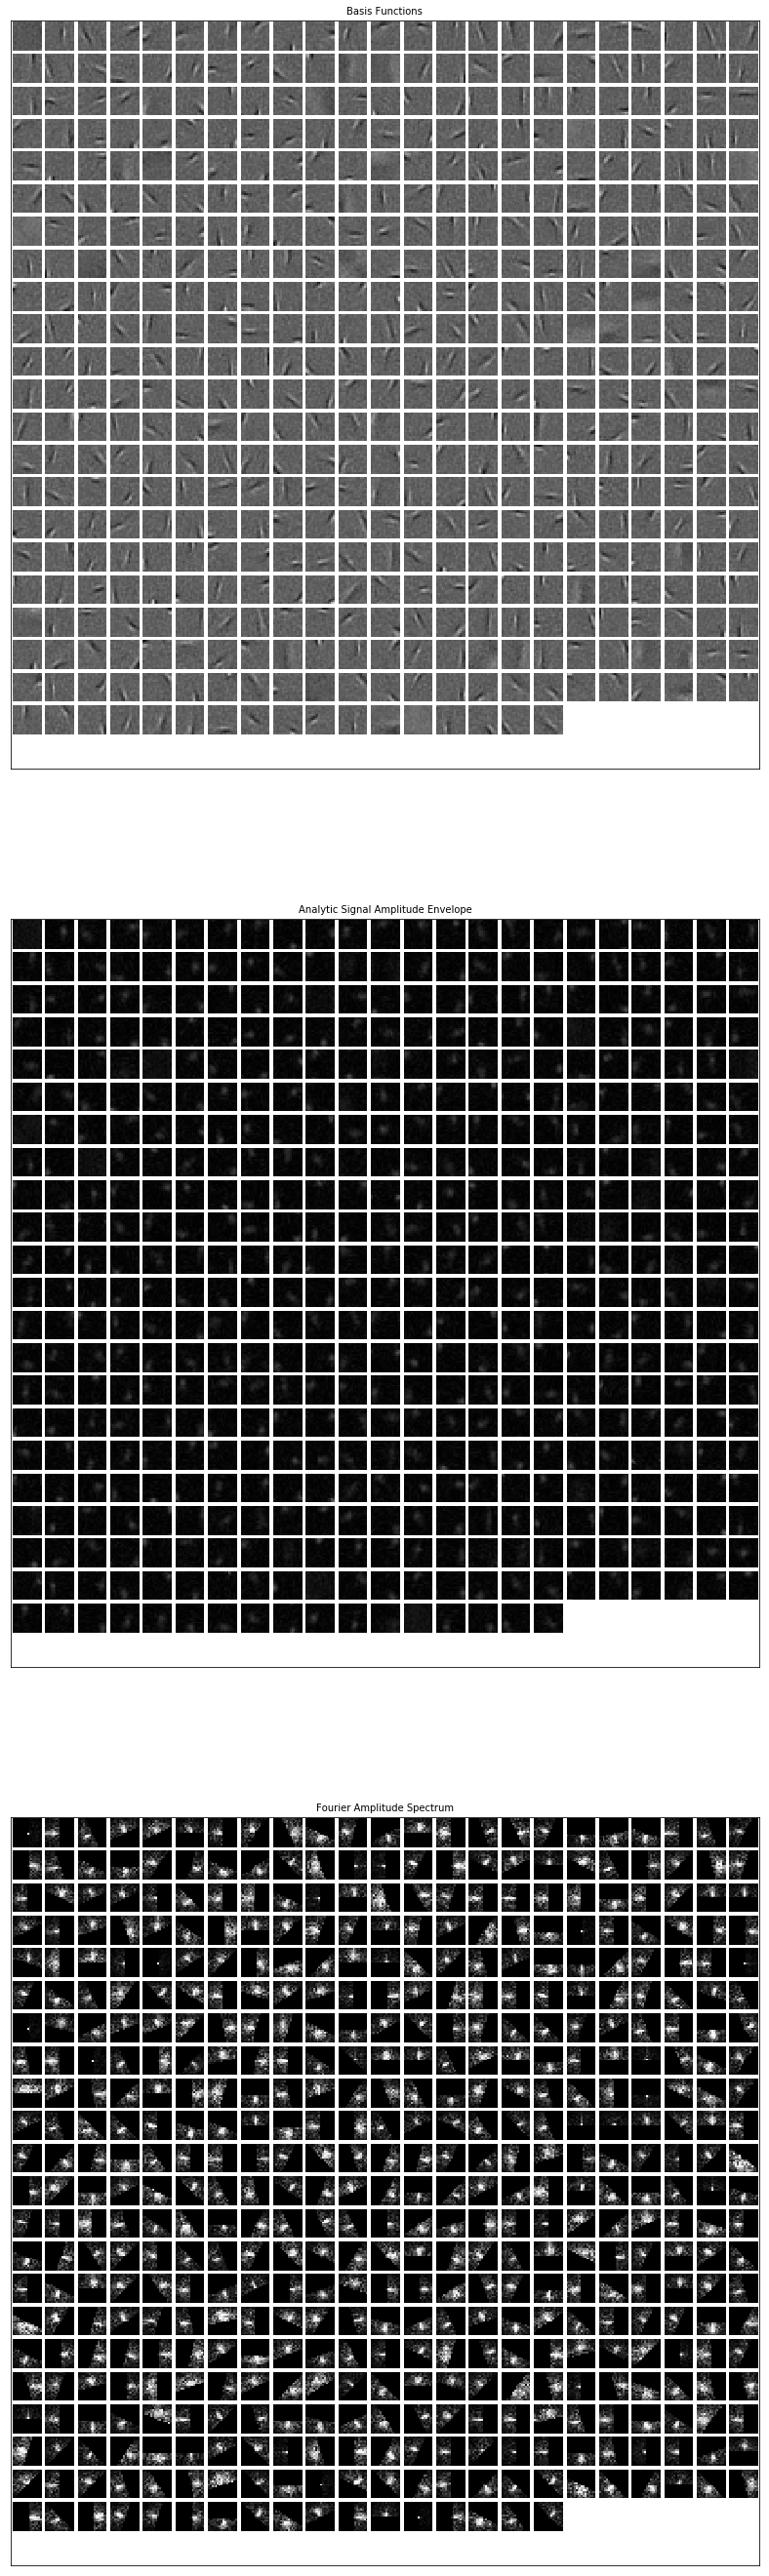

In [12]:
plot_hilbert_analysis(weights, params)

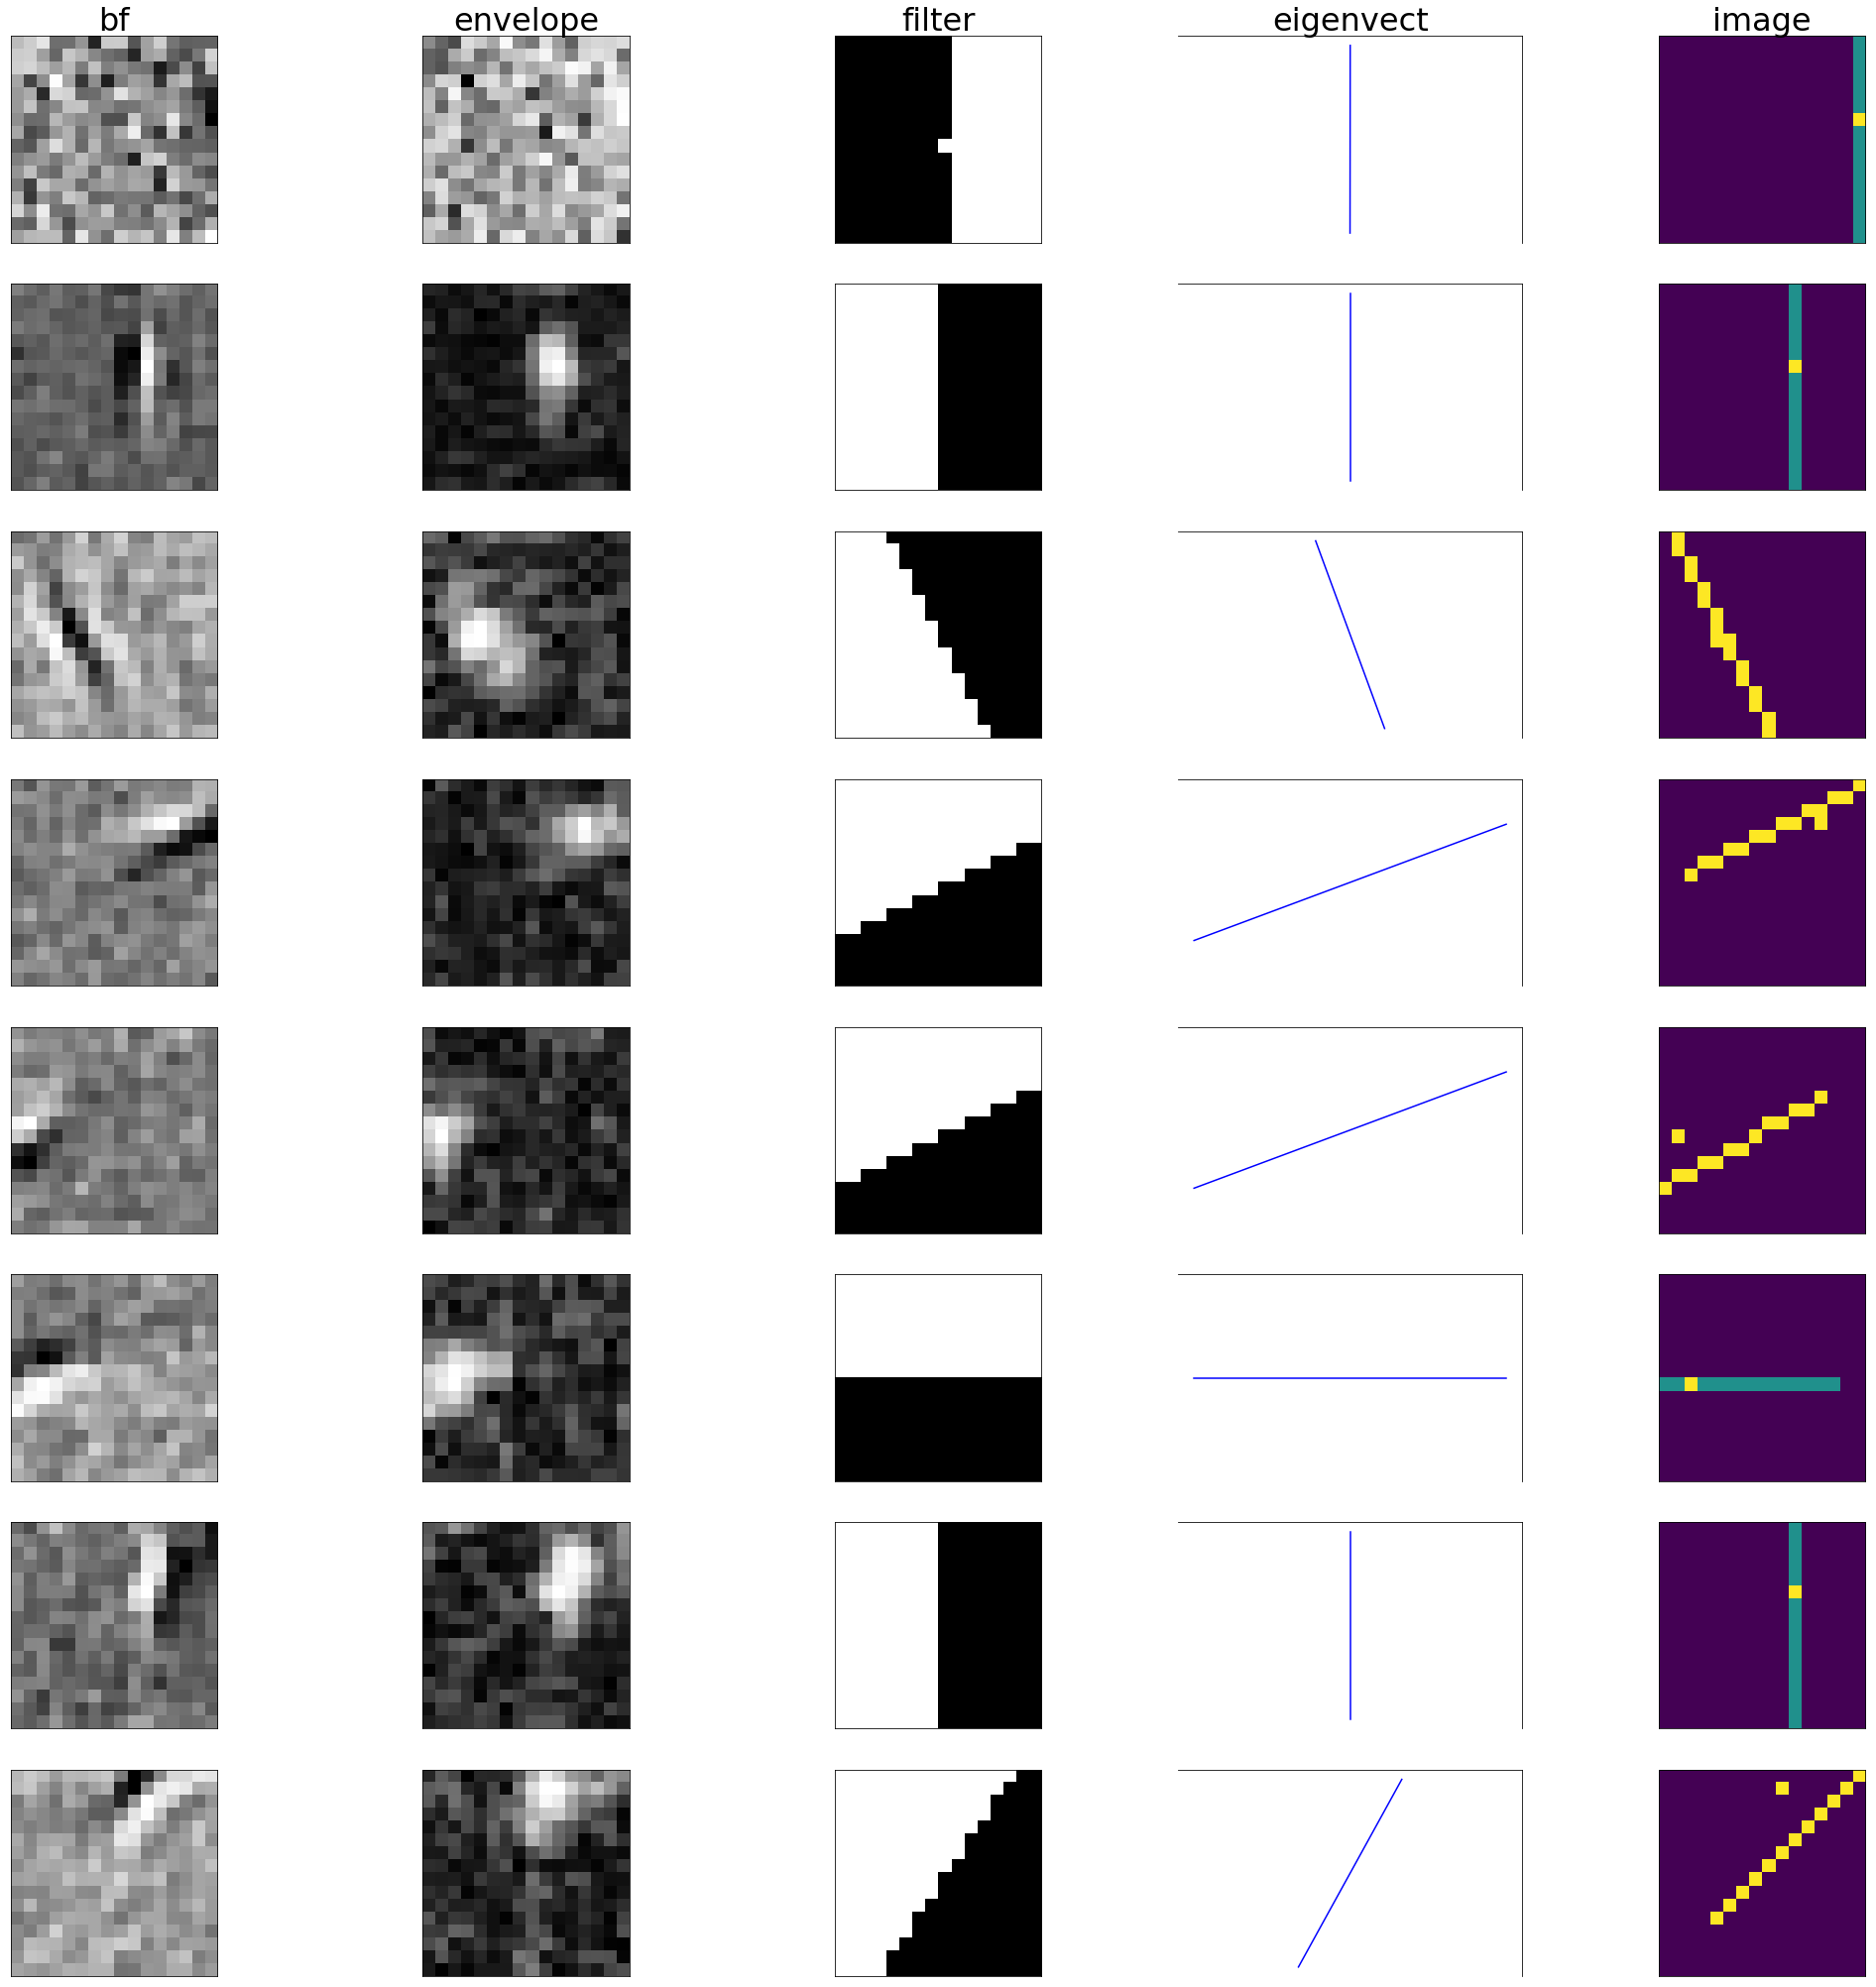

In [13]:
plot_bf_stats(weights, params) 

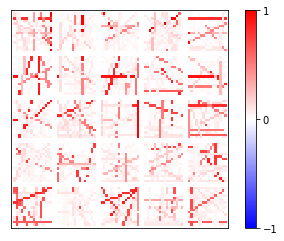

In [14]:
num_pooling_dims = 16
num_pooling_filters = 25
num_connected_weights = 10

plot_pooling_filters(num_pooling_dims, num_pooling_filters,
  num_connected_weights, weights, a_vals, params)